# Understanding the Problem

## Descrição

O conjunto de dados contêm observações diárias do clima de algumas estações meteorológicas na Austrália.
 
Os dados estão organizados em duas tabelas:

- `rain_data_aus.csv`: Contém a maior parte das informações, já centralizadas, de todas as estações.

- `wind_table_01.csv a wind_table_08.csv`: Contém informações sobre velocidade e orientação de ventos.

## Objetivo

Construir um modelo preditivo para determinar se vai ou não chover amanhã.

## Dicionário

Variable | Description
---------|------------
Date   |  The date of observation
Location   |  The common name of the location of the weather station
MinTemp   |  The minimum temperature in degrees celsius
MaxTemp   |  The maximum temperature in degrees celsius
Rainfall   |  The amount of rainfall recorded for the day in mm
Evaporation   |  The so-called Class A pan evaporation (mm) in the 24 hours to 9am
Sunshine   |  The number of hours of bright sunshine in the day.
WindGustDir   |  The direction of the strongest wind gust in the 24 hours to midnight
WindGustSpeed   |  The speed (km/h) of the strongest wind gust in the 24 hours to midnight
WindDir9am   |  Direction of the wind at 9am
WindDir3pm   |  Direction of the wind at 3pm
WindSpeed9am   |  Wind speed (km/hr) averaged over 10 minutes prior to 9am
WindSpeed3pm   |  Wind speed (km/hr) averaged over 10 minutes prior to 3pm
Humidity9am   |  Humidity (percent) at 9am
Humidity3pm   |  Humidity (percent) at 3pm
Pressure9am   |  Atmospheric pressure (hpa) reduced to mean sea level at 9am
Pressure3pm   |  Atmospheric pressure (hpa) reduced to mean sea level at 3pm
Cloud9am   |  Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.
Cloud3pm | Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cload9am for a description of the values
Temp9am |  Temperature (degrees C) at 9am
Temp3pm |  Temperature (degrees C) at 3pm
Precipitation9am |  The amount of rain in mm prior to 9am
Precipitation3pm |  The amount of rain in mm prior to 3pm
AmountOfRain |  The amount of rain in mm
Temp |  Temperature (degrees C)
Humidity |  Humidity (percent)
RainToday |  Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0
RainTomorrow |  The target variable. Did it rain tomorrow?

# Importing Libraries

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, plot_precision_recall_curve,\
log_loss, mean_squared_error, average_precision_score
from sklearn.linear_model import LogisticRegressionCV, ElasticNetCV, LogisticRegression
from sklearn.impute import KNNImputer

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

%matplotlib inline

# Importing Data

## Rain dataset

In [2]:
rain_data = pd.read_csv('data/rain_data_aus.csv')

In [3]:
rain_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
date                142193 non-null object
location            142193 non-null object
mintemp             141556 non-null float64
maxtemp             141871 non-null float64
rainfall            140787 non-null float64
evaporation         81350 non-null float64
sunshine            74377 non-null float64
humidity9am         140419 non-null float64
humidity3pm         138583 non-null float64
pressure9am         128179 non-null float64
pressure3pm         128212 non-null float64
cloud9am            88536 non-null float64
cloud3pm            85099 non-null float64
temp9am             141289 non-null float64
temp3pm             139467 non-null float64
raintoday           140787 non-null object
amountOfRain        142193 non-null float64
raintomorrow        142193 non-null object
temp                141871 non-null float64
humidity            138583 non-null float64
precipitation3pm 

In [4]:
rain_data.describe()

,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,amountOfRain,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000,141871.000000,138583.000000,142193.000000,142193.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2.360682,28.505419,61.991179,10.014164,10.000748,0.227804
std,6.403283,7.117618,8.465173,4.188537,3.781525,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,8.477969,10.237506,26.649111,3.169832,4.997908,0.272764
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000,-3.760000,2.000000,0.000000,-17.739346,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000,22.520000,44.000000,8.000000,6.650238,0.030055
50%,12.000000,22.600000,0.000000,4.800000,8.500000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000,28.520000,63.200000,10.000000,10.000009,0.100853
75%,16.800000,28.200000,0.800000,7.400000,10.600000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000,35.480000,80.000000,12.000000,13.389306,0.329507
max,33.900000,48.100000,371.000000,145.000000,14.500000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000,59.720000,122.000000,26.000000,32.478590,0.999400


In [5]:
rain_data.sort_values(['location', 'date'])

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,amountOfRain,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente
93856,2008-07-01,Adelaide,8.8,15.7,5.0,1.6,2.6,92.0,67.0,1017.4,1017.7,NaN,NaN,13.5,14.9,Yes,0.8,No,20.840000,82.4,11,6.311695,0.288803
93857,2008-07-02,Adelaide,12.7,15.8,0.8,1.4,7.8,75.0,52.0,1022.4,1022.6,NaN,NaN,13.7,15.5,No,0.0,No,20.960000,64.4,11,7.531120,0.047637
93858,2008-07-03,Adelaide,6.2,15.1,0.0,1.8,2.1,81.0,56.0,1027.8,1026.5,NaN,NaN,9.3,13.9,No,0.0,No,20.120000,69.2,7,17.529148,0.017562
93859,2008-07-04,Adelaide,5.3,15.9,0.0,1.4,8.0,71.0,46.0,1028.7,1025.6,NaN,NaN,10.2,15.3,No,0.0,No,21.080000,57.2,15,6.801071,0.012143
93860,2008-07-06,Adelaide,11.3,15.7,NaN,NaN,1.5,62.0,62.0,1019.5,1016.2,NaN,NaN,13.0,14.4,NaN,16.2,Yes,2.622380,76.4,15,13.384548,0.763329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105963,2017-06-20,Woomera,5.6,19.7,0.0,2.2,0.0,61.0,28.0,1028.1,1025.9,0.0,NaN,11.1,19.2,No,0.0,No,25.640000,35.6,14,7.863922,0.005933
105964,2017-06-21,Woomera,5.8,19.9,0.0,2.0,NaN,52.0,22.0,1027.9,1025.1,1.0,NaN,11.1,19.1,No,0.0,No,25.880000,28.4,6,11.649692,0.007330
105965,2017-06-22,Woomera,7.8,19.0,0.0,1.4,NaN,48.0,37.0,1025.8,1022.2,8.0,6.0,11.1,18.0,No,0.0,No,24.800000,46.4,21,5.146538,0.075571
105966,2017-06-23,Woomera,8.0,22.5,0.0,4.0,NaN,57.0,31.0,1021.0,1018.2,7.0,3.0,11.5,21.5,No,0.0,No,2.525443,39.2,10,8.775399,0.065521


## Wind dataset

In [6]:
wind_data_ls = []
for i in range(1, 9):
    df = pd.read_csv(f'data/wind_table_0{i}.csv')
    df.columns = ['date', 'location', 'windgustdir', 'windgustspeed', 'winddir9am',
                  'winddir3pm', 'windspeed9am', 'windspeed3pm']
    wind_data_ls.append(df)
    
wind_data = pd.concat(wind_data_ls, axis=0).reset_index(drop=True).drop_duplicates()

wind_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 142192
Data columns (total 8 columns):
date             142193 non-null object
location         142193 non-null object
windgustdir      132863 non-null object
windgustspeed    132923 non-null float64
winddir9am       132180 non-null object
winddir3pm       138415 non-null object
windspeed9am     140845 non-null float64
windspeed3pm     139563 non-null float64
dtypes: float64(3), object(5)
memory usage: 9.8+ MB


In [7]:
wind_data.describe()

,windgustspeed,windspeed9am,windspeed3pm
count,132923.000000,140845.000000,139563.000000
mean,39.984292,14.001988,18.637576
std,13.588801,8.893337,8.803345
min,6.000000,0.000000,0.000000
25%,31.000000,7.000000,13.000000
50%,39.000000,13.000000,19.000000
75%,48.000000,19.000000,24.000000
max,135.000000,130.000000,87.000000


In [8]:
wind_data.sort_values(['location', 'date'])

,date,location,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm
398,2008-07-01,Adelaide,NW,48.0,SW,W,13.0,15.0
406,2008-07-02,Adelaide,SW,35.0,SSW,SW,13.0,15.0
414,2008-07-03,Adelaide,W,20.0,NNE,SW,2.0,11.0
422,2008-07-04,Adelaide,NNE,30.0,NNE,NE,6.0,13.0
437,2008-07-06,Adelaide,NNW,52.0,NNE,NNW,15.0,22.0
...,...,...,...,...,...,...,...,...
141947,2017-06-20,Woomera,N,20.0,E,ESE,9.0,7.0
141994,2017-06-21,Woomera,ENE,22.0,ESE,ESE,11.0,9.0
142042,2017-06-22,Woomera,NNE,31.0,ENE,NNW,13.0,17.0
142091,2017-06-23,Woomera,NNW,33.0,N,NW,13.0,15.0


## Joining both datasets

In [9]:
full_data = (pd.merge(rain_data,
                      wind_data,
                      on=['date', 'location'])
             .sort_values(['location', 'date'])
             .reset_index(drop=True))

full_data

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,amountOfRain,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm
0,2008-07-01,Adelaide,8.8,15.7,5.0,1.6,2.6,92.0,67.0,1017.4,1017.7,NaN,NaN,13.5,14.9,Yes,0.8,No,20.840000,82.4,11,6.311695,0.288803,NW,48.0,SW,W,13.0,15.0
1,2008-07-02,Adelaide,12.7,15.8,0.8,1.4,7.8,75.0,52.0,1022.4,1022.6,NaN,NaN,13.7,15.5,No,0.0,No,20.960000,64.4,11,7.531120,0.047637,SW,35.0,SSW,SW,13.0,15.0
2,2008-07-03,Adelaide,6.2,15.1,0.0,1.8,2.1,81.0,56.0,1027.8,1026.5,NaN,NaN,9.3,13.9,No,0.0,No,20.120000,69.2,7,17.529148,0.017562,W,20.0,NNE,SW,2.0,11.0
3,2008-07-04,Adelaide,5.3,15.9,0.0,1.4,8.0,71.0,46.0,1028.7,1025.6,NaN,NaN,10.2,15.3,No,0.0,No,21.080000,57.2,15,6.801071,0.012143,NNE,30.0,NNE,NE,6.0,13.0
4,2008-07-06,Adelaide,11.3,15.7,NaN,NaN,1.5,62.0,62.0,1019.5,1016.2,NaN,NaN,13.0,14.4,NaN,16.2,Yes,2.622380,76.4,15,13.384548,0.763329,NNW,52.0,NNE,NNW,15.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Woomera,5.6,19.7,0.0,2.2,0.0,61.0,28.0,1028.1,1025.9,0.0,NaN,11.1,19.2,No,0.0,No,25.640000,35.6,14,7.863922,0.005933,N,20.0,E,ESE,9.0,7.0
142189,2017-06-21,Woomera,5.8,19.9,0.0,2.0,NaN,52.0,22.0,1027.9,1025.1,1.0,NaN,11.1,19.1,No,0.0,No,25.880000,28.4,6,11.649692,0.007330,ENE,22.0,ESE,ESE,11.0,9.0
142190,2017-06-22,Woomera,7.8,19.0,0.0,1.4,NaN,48.0,37.0,1025.8,1022.2,8.0,6.0,11.1,18.0,No,0.0,No,24.800000,46.4,21,5.146538,0.075571,NNE,31.0,ENE,NNW,13.0,17.0
142191,2017-06-23,Woomera,8.0,22.5,0.0,4.0,NaN,57.0,31.0,1021.0,1018.2,7.0,3.0,11.5,21.5,No,0.0,No,2.525443,39.2,10,8.775399,0.065521,NNW,33.0,N,NW,13.0,15.0


# Data Wrangling 

## Preprocessing

In [10]:
full_data['date'] = pd.to_datetime(full_data['date'], infer_datetime_format=True).dt.month

In [11]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 29 columns):
date                142193 non-null int64
location            142193 non-null object
mintemp             141556 non-null float64
maxtemp             141871 non-null float64
rainfall            140787 non-null float64
evaporation         81350 non-null float64
sunshine            74377 non-null float64
humidity9am         140419 non-null float64
humidity3pm         138583 non-null float64
pressure9am         128179 non-null float64
pressure3pm         128212 non-null float64
cloud9am            88536 non-null float64
cloud3pm            85099 non-null float64
temp9am             141289 non-null float64
temp3pm             139467 non-null float64
raintoday           140787 non-null object
amountOfRain        142193 non-null float64
raintomorrow        142193 non-null object
temp                141871 non-null float64
humidity            138583 non-null float64
precipitation3pm  

In [12]:
full_data[['raintoday', 'rainfall', 'raintomorrow', 'amountOfRain']].head(20)

,raintoday,rainfall,raintomorrow,amountOfRain
0,Yes,5.0,No,0.8
1,No,0.8,No,0.0
2,No,0.0,No,0.0
3,No,0.0,No,0.0
4,NaN,NaN,Yes,16.2
5,Yes,16.2,Yes,17.0
6,Yes,17.0,Yes,1.8
7,Yes,1.8,Yes,9.0
8,Yes,9.0,No,0.2
9,NaN,NaN,Yes,3.8


In [13]:
idx = full_data[full_data['raintoday'].isnull()].index
full_data.loc[idx, 'raintoday'] = full_data.loc[idx - 1, 'raintomorrow'].values
full_data.loc[idx, 'rainfall'] = full_data.loc[idx - 1, 'amountOfRain'].values

mapping = {'No': 0, 'Yes': 1}
full_data['raintoday'] = full_data['raintoday'].map(mapping)
full_data['raintomorrow'] = full_data['raintomorrow'].map(mapping)

# dropping amountOfRain to avoid data leakage
full_data.drop('amountOfRain', axis=1, inplace=True)

full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 28 columns):
date                142193 non-null int64
location            142193 non-null object
mintemp             141556 non-null float64
maxtemp             141871 non-null float64
rainfall            142193 non-null float64
evaporation         81350 non-null float64
sunshine            74377 non-null float64
humidity9am         140419 non-null float64
humidity3pm         138583 non-null float64
pressure9am         128179 non-null float64
pressure3pm         128212 non-null float64
cloud9am            88536 non-null float64
cloud3pm            85099 non-null float64
temp9am             141289 non-null float64
temp3pm             139467 non-null float64
raintoday           142193 non-null int64
raintomorrow        142193 non-null int64
temp                141871 non-null float64
humidity            138583 non-null float64
precipitation3pm    142193 non-null int64
precipitation9am    14

In [14]:
full_data.isnull().mean().sort_values(ascending=False)

sunshine            0.476929
evaporation         0.427890
cloud3pm            0.401525
cloud9am            0.377353
pressure9am         0.098556
pressure3pm         0.098324
winddir9am          0.070418
windgustdir         0.065615
windgustspeed       0.065193
winddir3pm          0.026570
humidity            0.025388
humidity3pm         0.025388
temp3pm             0.019171
windspeed3pm        0.018496
humidity9am         0.012476
windspeed9am        0.009480
temp9am             0.006358
mintemp             0.004480
temp                0.002265
maxtemp             0.002265
raintoday           0.000000
raintomorrow        0.000000
precipitation3pm    0.000000
precipitation9am    0.000000
modelo_vigente      0.000000
rainfall            0.000000
location            0.000000
date                0.000000
dtype: float64

In [15]:
# if wind speed equals 0, then there should be no speed direction
full_data.loc[full_data['windspeed3pm'] == 0, 'winddir3pm'] = 'NA'
full_data.loc[full_data['windspeed9am'] == 0, 'winddir9am'] = 'NA'
full_data.loc[full_data['windgustspeed'] == 0, 'windgustdir'] = 'NA'

In [16]:
print(full_data.loc[full_data['windspeed3pm'] == 0, 'winddir3pm'].notnull().all())
print(full_data.loc[full_data['windspeed9am'] == 0, 'winddir9am'].notnull().all())
print(full_data.loc[full_data['windgustspeed'] == 0, 'windgustdir'].notnull().all())

True
True
True


In [17]:
full_data.isnull().mean().sort_values(ascending=False)

sunshine            0.476929
evaporation         0.427890
cloud3pm            0.401525
cloud9am            0.377353
pressure9am         0.098556
pressure3pm         0.098324
windgustdir         0.065615
windgustspeed       0.065193
humidity            0.025388
humidity3pm         0.025388
temp3pm             0.019171
winddir3pm          0.018862
windspeed3pm        0.018496
humidity9am         0.012476
winddir9am          0.009853
windspeed9am        0.009480
temp9am             0.006358
mintemp             0.004480
temp                0.002265
maxtemp             0.002265
raintoday           0.000000
raintomorrow        0.000000
precipitation3pm    0.000000
precipitation9am    0.000000
modelo_vigente      0.000000
rainfall            0.000000
location            0.000000
date                0.000000
dtype: float64

## Cleaning inconsistent data

In [18]:
df1 = full_data.loc[(full_data['temp3pm'] > full_data['maxtemp']), ['maxtemp', 'temp3pm']]
df2 = full_data.loc[(full_data['temp9am'] > full_data['maxtemp']), ['maxtemp', 'temp9am']]

display(df1)
display(df2)

,maxtemp,temp3pm
11863,22.0,22.1
11871,26.0,26.3
11884,26.0,26.1
11885,24.0,24.1
26928,28.0,28.3
26944,29.0,29.1
33408,16.0,16.3
33418,19.0,19.3
33428,13.0,13.2
33433,19.0,19.3


,maxtemp,temp9am
5679,19.8,20.1
5737,13.2,13.8
6040,16.5,16.7
26926,25.0,25.6
26983,24.0,24.3
33415,17.0,17.4
36558,24.0,24.4
51726,13.4,13.5
71433,19.8,21.2
73255,29.2,29.6


In [19]:
full_data.loc[df1.index, 'maxtemp'] = full_data.loc[df1.index, 'temp3pm']
full_data.loc[df2.index, 'maxtemp'] = full_data.loc[df2.index, 'temp9am']

In [20]:
((full_data['temp3pm'] <= full_data['maxtemp']) & (full_data['temp9am'] <= full_data['maxtemp'])).all()

False

In [21]:
df3 = full_data.loc[(full_data['temp3pm'] < full_data['mintemp']), ['mintemp', 'temp3pm']]
df4 = full_data.loc[(full_data['temp9am'] < full_data['mintemp']), ['mintemp', 'temp9am']]

display(df3)
display(df4)

,mintemp,temp3pm
14,9.9,9.6
69,13.1,11.3
117,22.5,22.0
227,20.7,17.9
278,21.3,18.0
...,...,...
140653,25.1,21.7
140656,15.4,15.2
141601,16.7,16.6
142016,26.3,25.3


,mintemp,temp9am
3852,19.3,19.2
5015,12.5,12.0
28397,19.5,17.3
112121,22.8,22.7
126313,15.2,15.1


In [22]:
full_data.loc[df3.index, 'mintemp'] = full_data.loc[df3.index, 'temp3pm']
full_data.loc[df4.index, 'mintemp'] = full_data.loc[df4.index, 'temp9am']

In [23]:
((full_data['temp3pm'] >= full_data['mintemp']) & (full_data['temp9am'] >= full_data['mintemp'])).all()

False

In [24]:
inconsistent_cloud = full_data[(full_data['cloud3pm'] == 9) | (full_data['cloud9am'] == 9)]
display(inconsistent_cloud)
full_data = full_data.drop(inconsistent_cloud.index, axis=0).reset_index(drop=True)

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm
28917,5,Canberra,0.6,14.5,0.0,NaN,7.8,99.0,41.0,1022.4,1020.7,9.0,NaN,4.4,14.2,0,0,19.40,51.2,10,12.398522,0.024968,SW,30.0,NNW,SSW,4.0,9.0
108627,9,Sydney,17.0,21.8,4.4,11.2,8.0,40.0,36.0,996.8,997.8,9.0,3.0,17.3,20.9,1,0,28.16,45.2,10,11.419590,0.120108,NaN,NaN,W,W,30.0,37.0
140567,11,Woomera,10.6,24.6,0.2,11.6,11.4,45.0,13.0,1019.0,1015.2,6.0,9.0,14.8,23.7,0,0,31.52,17.6,11,12.905862,0.011199,SSE,39.0,SE,ESE,26.0,17.0


In [25]:
((full_data.dropna()['cloud3pm'] <= 8) & (full_data.dropna()['cloud9am'] <= 8)).all()

True

## Splitting the dataset

In [26]:
# full-train/test split
X_train, X_test, y_train, y_test = train_test_split(full_data.drop(['raintomorrow'], axis=1),
                                                    full_data['raintomorrow'],
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=full_data[['location', 'raintomorrow']])

# rejoining the datasets for ease of cleaning
df_train = pd.concat([y_train, X_train], axis=1)
df_test = pd.concat([y_test, X_test], axis=1)

In [27]:
cols = pd.Series(df_train.columns)
cols_date = cols[cols.str.startswith('date')].tolist()

## Data analysis (and some more data cleaning)

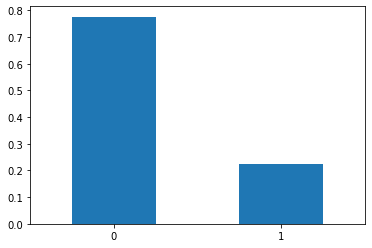

In [28]:
# raintomorrow data is heavily skewed
df_train['raintomorrow'].value_counts(normalize=True).plot.bar(rot=0);

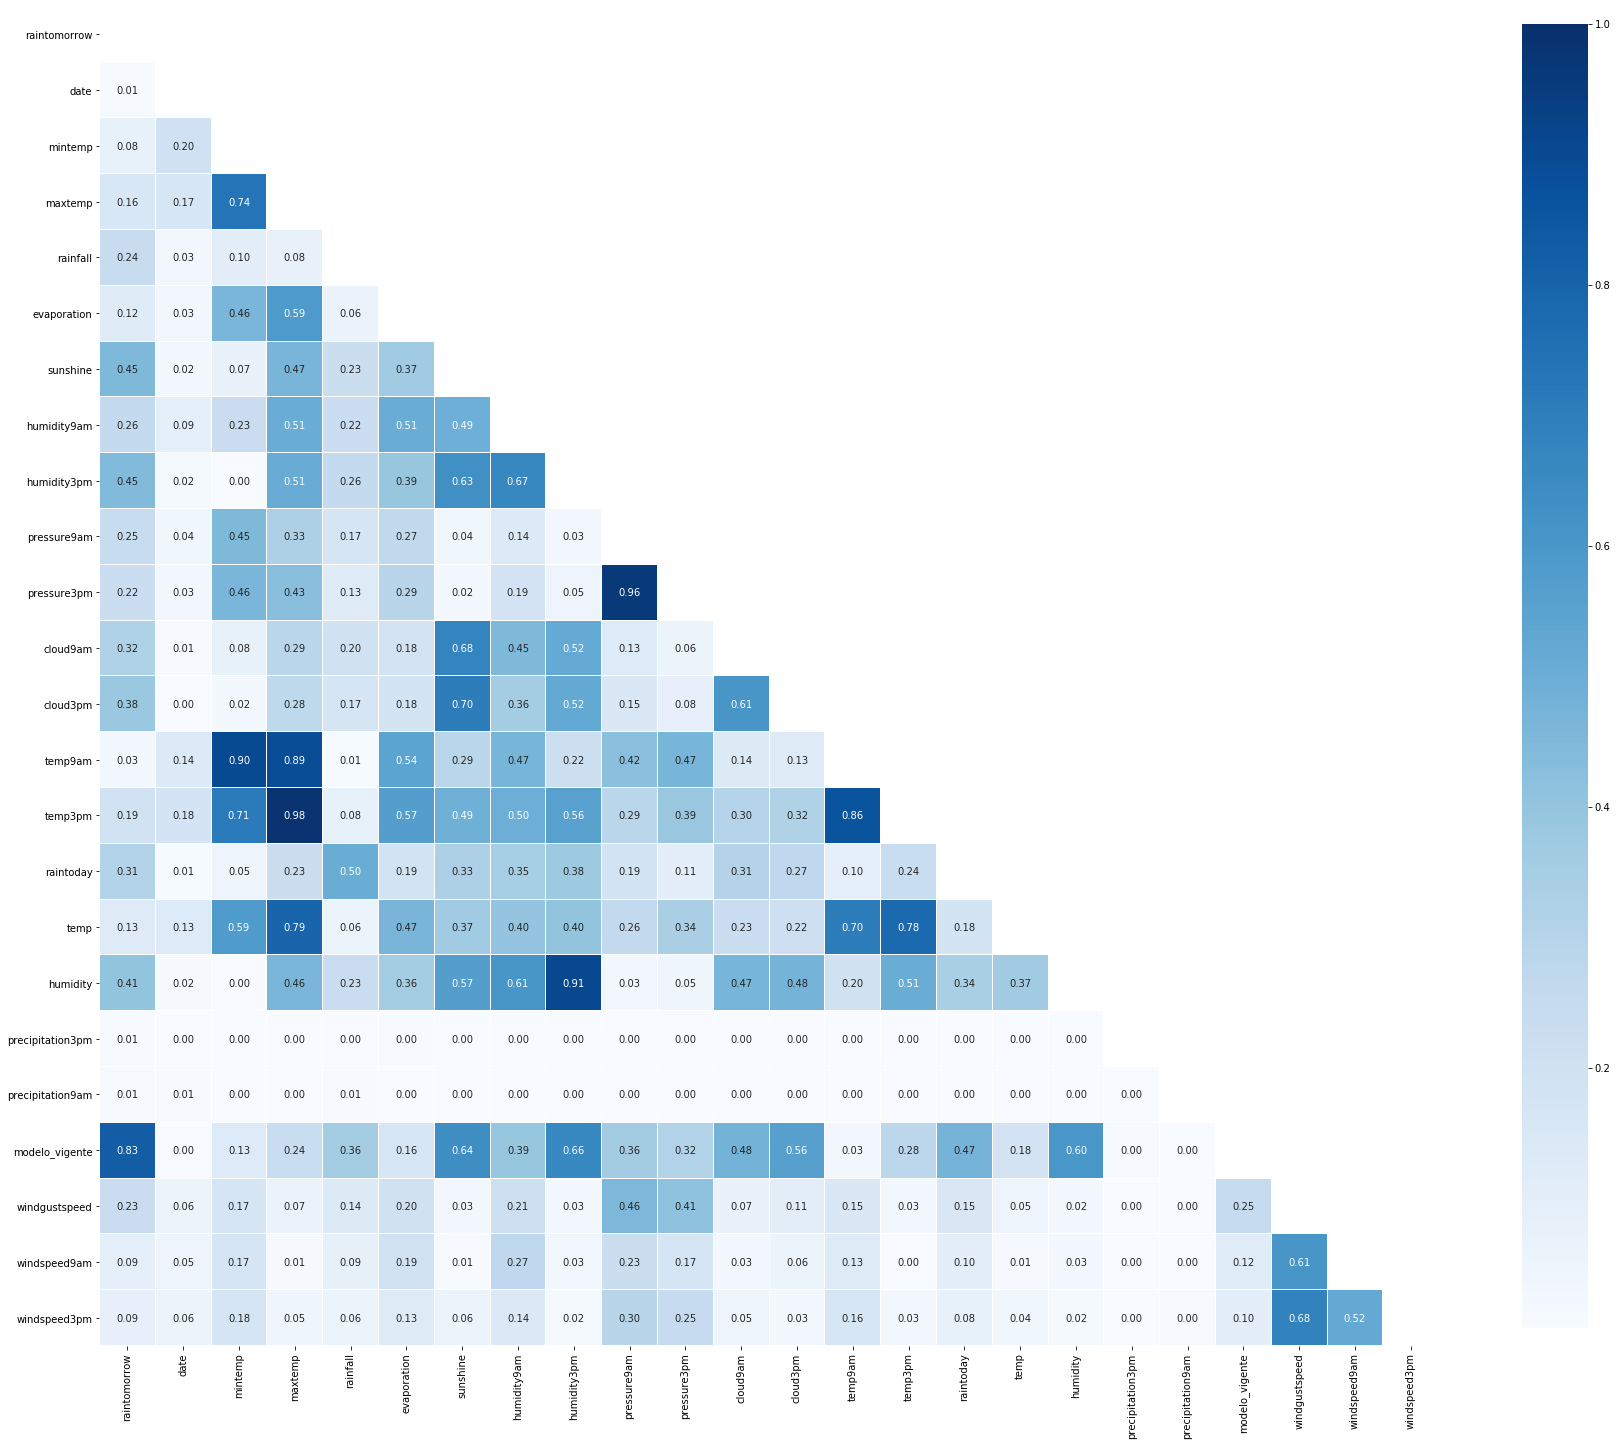

In [29]:
# sunshine, cloud9am and cloud3pm have a moderately high correlation with raintomorrow but many missing values
# precipitation variables look suspicious
train_corr_df = df_train.corr().abs()

fig, ax = plt.subplots(figsize=(30, 30))
mask = np.zeros_like(train_corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train_corr_df,
            mask=mask, cmap='Blues',
            square=True,
            cbar_kws={"shrink": .8},
            linewidths=0.1,
            annot=True,
            fmt='.2f',
            ax=ax)
ax.set_ylim(len(train_corr_df), 0, 0);

In [30]:
df_train.describe()

,raintomorrow,date,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente,windgustspeed,windspeed9am,windspeed3pm
count,99533.000000,99533.000000,99085.000000,99308.000000,99533.000000,56993.000000,52101.000000,98286.000000,97001.000000,89726.000000,89755.000000,62003.000000,59606.000000,98889.000000,97616.000000,99533.000000,99308.000000,97001.000000,99533.000000,99533.000000,99533.000000,93031.000000,98580.000000,97671.000000
mean,0.224157,6.400048,12.177184,23.215958,2.376657,5.482770,7.625013,68.811530,51.509778,1017.639509,1015.252749,4.436818,4.505083,16.985402,21.676173,0.224719,28.487099,62.020939,10.015965,9.992922,0.228334,40.015683,14.008338,18.647644
std,0.417028,3.426696,6.394400,7.116930,8.476396,4.211224,3.780430,19.083243,20.822531,7.113524,7.039480,2.890375,2.721450,6.492186,6.940328,0.417400,10.240051,26.680506,3.169164,4.989443,0.272990,13.600476,8.901635,8.809240
min,0.000000,1.000000,-8.500000,-4.100000,0.000000,0.000000,0.000000,1.000000,0.000000,980.500000,979.000000,0.000000,0.000000,-7.000000,-5.100000,0.000000,-2.920000,2.000000,0.000000,-11.023931,0.000000,6.000000,0.000000,0.000000
25%,0.000000,3.000000,7.600000,17.900000,0.000000,2.600000,4.900000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000,22.520000,44.000000,8.000000,6.647850,0.030173,31.000000,7.000000,13.000000
50%,0.000000,6.000000,12.000000,22.600000,0.000000,4.800000,8.500000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000,28.520000,63.200000,10.000000,9.991605,0.101132,39.000000,13.000000,19.000000
75%,0.000000,9.000000,16.800000,28.200000,0.800000,7.400000,10.600000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.000000,35.480000,80.000000,12.000000,13.372538,0.331378,48.000000,19.000000,24.000000
max,1.000000,12.000000,33.900000,48.100000,367.600000,145.000000,14.300000,100.000000,100.000000,1041.000000,1039.600000,8.000000,8.000000,40.200000,46.700000,1.000000,59.720000,122.000000,26.000000,30.355797,0.999400,135.000000,130.000000,83.000000


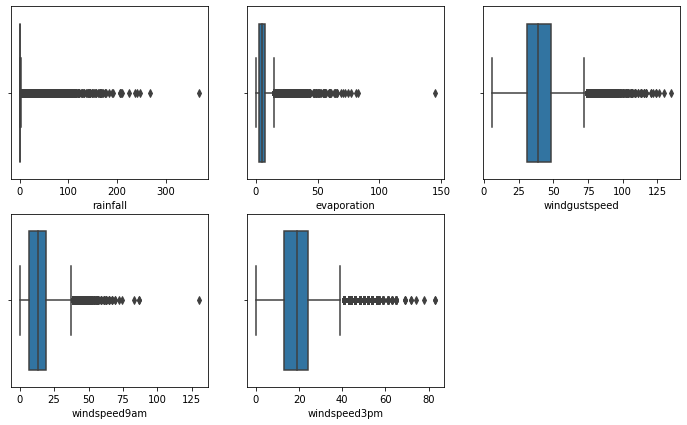

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))

sns.boxplot('rainfall', data=df_train, ax=ax[0, 0])
sns.boxplot('evaporation', data=df_train, ax=ax[0, 1])
sns.boxplot('windgustspeed', data=df_train, ax=ax[0, 2])
sns.boxplot('windspeed9am', data=df_train, ax=ax[1, 0])
sns.boxplot('windspeed3pm', data=df_train, ax=ax[1, 1])

fig.delaxes(ax[1, 2]);

### Working only with the rain data for now

In [32]:
rain_cols = list(df_train.columns)[:22]
wind_cols = list(df_train.columns)[22:]
df_train[rain_cols].corr().abs()['raintomorrow'].sort_values(ascending=False)

raintomorrow        1.000000
modelo_vigente      0.825693
sunshine            0.450342
humidity3pm         0.445585
humidity            0.405337
cloud3pm            0.383496
cloud9am            0.320239
raintoday           0.309564
humidity9am         0.257540
pressure9am         0.245298
rainfall            0.239141
pressure3pm         0.224736
temp3pm             0.191891
maxtemp             0.158823
temp                0.125291
evaporation         0.119178
mintemp             0.082153
temp9am             0.025010
date                0.006690
precipitation3pm    0.005586
precipitation9am    0.005501
Name: raintomorrow, dtype: float64

#### Precipitation

In [33]:
df_train[['precipitation3pm', 'precipitation9am']].describe()

,precipitation3pm,precipitation9am
count,99533.000000,99533.000000
mean,10.015965,9.992922
std,3.169164,4.989443
min,0.000000,-11.023931
25%,8.000000,6.647850
50%,10.000000,9.991605
75%,12.000000,13.372538
max,26.000000,30.355797


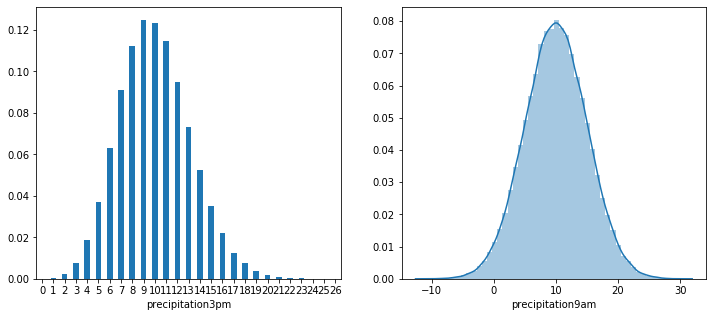

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

df_train['precipitation3pm'].value_counts(normalize=True).sort_index().plot.bar(rot=0, ax=ax[0])
sns.distplot(df_train['precipitation9am'], ax=ax[1])

ax[0].set_xlabel('precipitation3pm');

In [35]:
df_train.drop(['precipitation3pm', 'precipitation9am'], axis=1, inplace=True)
df_test.drop(['precipitation3pm', 'precipitation9am'], axis=1, inplace=True)

rain_cols.remove('precipitation3pm')
rain_cols.remove('precipitation9am')

#### Temperature

In [36]:
df_temp = df_train[['mintemp', 'temp', 'maxtemp', 'temp9am', 'temp3pm']]

df_temp.describe()

,mintemp,temp,maxtemp,temp9am,temp3pm
count,99085.000000,99308.000000,99308.000000,98889.000000,97616.000000
mean,12.177184,28.487099,23.215958,16.985402,21.676173
std,6.394400,10.240051,7.116930,6.492186,6.940328
min,-8.500000,-2.920000,-4.100000,-7.000000,-5.100000
25%,7.600000,22.520000,17.900000,12.300000,16.600000
50%,12.000000,28.520000,22.600000,16.700000,21.100000
75%,16.800000,35.480000,28.200000,21.600000,26.400000
max,33.900000,59.720000,48.100000,40.200000,46.700000


/home/jeffc/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/jeffc/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


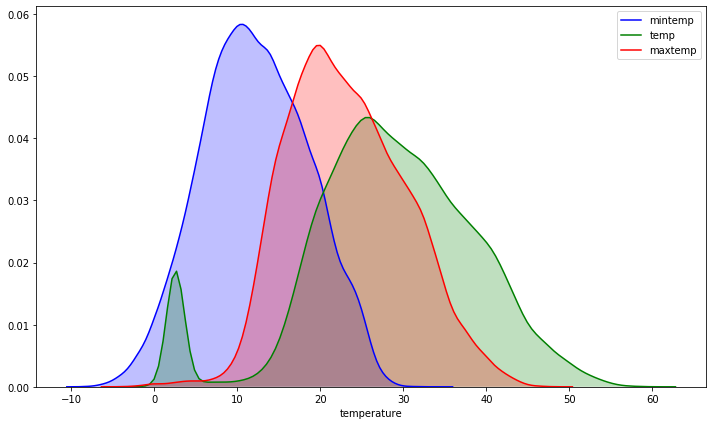

In [37]:
fig, ax = plt.subplots(figsize=(12,7))

sns.kdeplot(df_temp['mintemp'], shade=True, color='blue', ax=ax)
sns.kdeplot(df_temp['temp'], shade=True, color='green', ax=ax)
sns.kdeplot(df_temp['maxtemp'], shade=True, color='red', ax=ax)

plt.xlabel('temperature')
plt.legend(['mintemp', 'temp', 'maxtemp']);

In [38]:
df_temp.corr()

,mintemp,temp,maxtemp,temp9am,temp3pm
mintemp,1.000000,0.585587,0.738153,0.902322,0.711539
temp,0.585587,1.000000,0.793419,0.703228,0.781008
maxtemp,0.738153,0.793419,1.000000,0.887363,0.984502
temp9am,0.902322,0.703228,0.887363,1.000000,0.860886
temp3pm,0.711539,0.781008,0.984502,0.860886,1.000000


In [39]:
df_train.drop('temp', axis=1, inplace=True)
df_test.drop('temp', axis=1, inplace=True)

rain_cols.remove('temp')

#### Humidity

In [40]:
df_humid = df_train[['humidity','humidity9am', 'humidity3pm']]

df_humid.describe()

,humidity,humidity9am,humidity3pm
count,97001.000000,98286.000000,97001.000000
mean,62.020939,68.811530,51.509778
std,26.680506,19.083243,20.822531
min,2.000000,1.000000,0.000000
25%,44.000000,57.000000,37.000000
50%,63.200000,70.000000,52.000000
75%,80.000000,83.000000,66.000000
max,122.000000,100.000000,100.000000


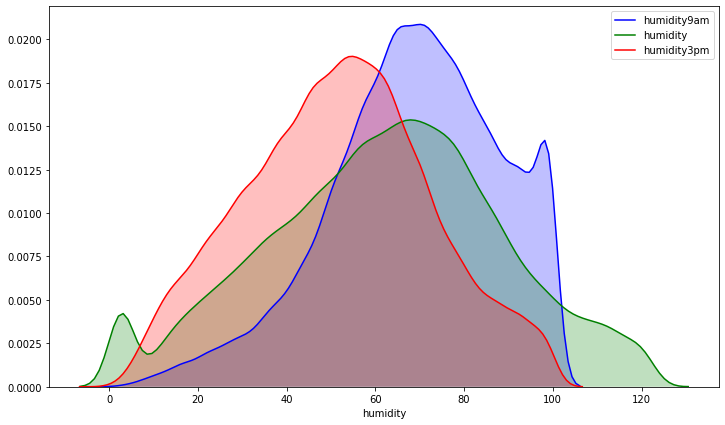

In [41]:
fig, ax = plt.subplots(figsize=(12,7))

sns.kdeplot(df_humid['humidity9am'], shade=True, color='blue', ax=ax)
sns.kdeplot(df_humid['humidity'], shade=True, color='green', ax=ax)
sns.kdeplot(df_humid['humidity3pm'], shade=True, color='red', ax=ax)

plt.xlabel('humidity')
plt.legend(['humidity9am', 'humidity', 'humidity3pm']);

In [42]:
df_humid.corr()

,humidity,humidity9am,humidity3pm
humidity,1.000000,0.607059,0.908925
humidity9am,0.607059,1.000000,0.667449
humidity3pm,0.908925,0.667449,1.000000


In [43]:
df_train.drop('humidity', axis=1, inplace=True)
df_test.drop('humidity', axis=1, inplace=True)

rain_cols.remove('humidity')

In [44]:
df_train.isnull().mean().sort_values(ascending=False)

sunshine          0.476545
evaporation       0.427396
cloud3pm          0.401143
cloud9am          0.377061
pressure9am       0.098530
pressure3pm       0.098239
windgustdir       0.065727
windgustspeed     0.065325
humidity3pm       0.025439
temp3pm           0.019260
winddir3pm        0.019089
windspeed3pm      0.018707
humidity9am       0.012529
winddir9am        0.009987
windspeed9am      0.009575
temp9am           0.006470
mintemp           0.004501
maxtemp           0.002261
raintoday         0.000000
modelo_vigente    0.000000
rainfall          0.000000
location          0.000000
date              0.000000
raintomorrow      0.000000
dtype: float64

### Dropping rows from columns that have less than 10% missing values

In [45]:

cols_na = ['maxtemp', 'mintemp', 'temp9am', 'temp3pm',
           'pressure3pm', 'pressure9am', 'winddir9am', 'winddir3pm',
           'windgustdir', 'windgustspeed', 'windspeed9am',
           'windspeed3pm','humidity9am', 'humidity3pm']
df_train = df_train.dropna(subset=cols_na, axis=0).reset_index(drop=True)
df_test = df_test.dropna(subset=cols_na, axis=0).reset_index(drop=True)

## Data imputation

In [46]:
# null counts before imputation
display(df_train.isnull().sum()[df_train.isnull().sum() > 0])
display(df_test.isnull().sum()[df_test.isnull().sum() > 0])

evaporation    31820
sunshine       35762
cloud9am       29298
cloud3pm       30278
dtype: int64

evaporation    13703
sunshine       15353
cloud9am       12620
cloud3pm       13019
dtype: int64

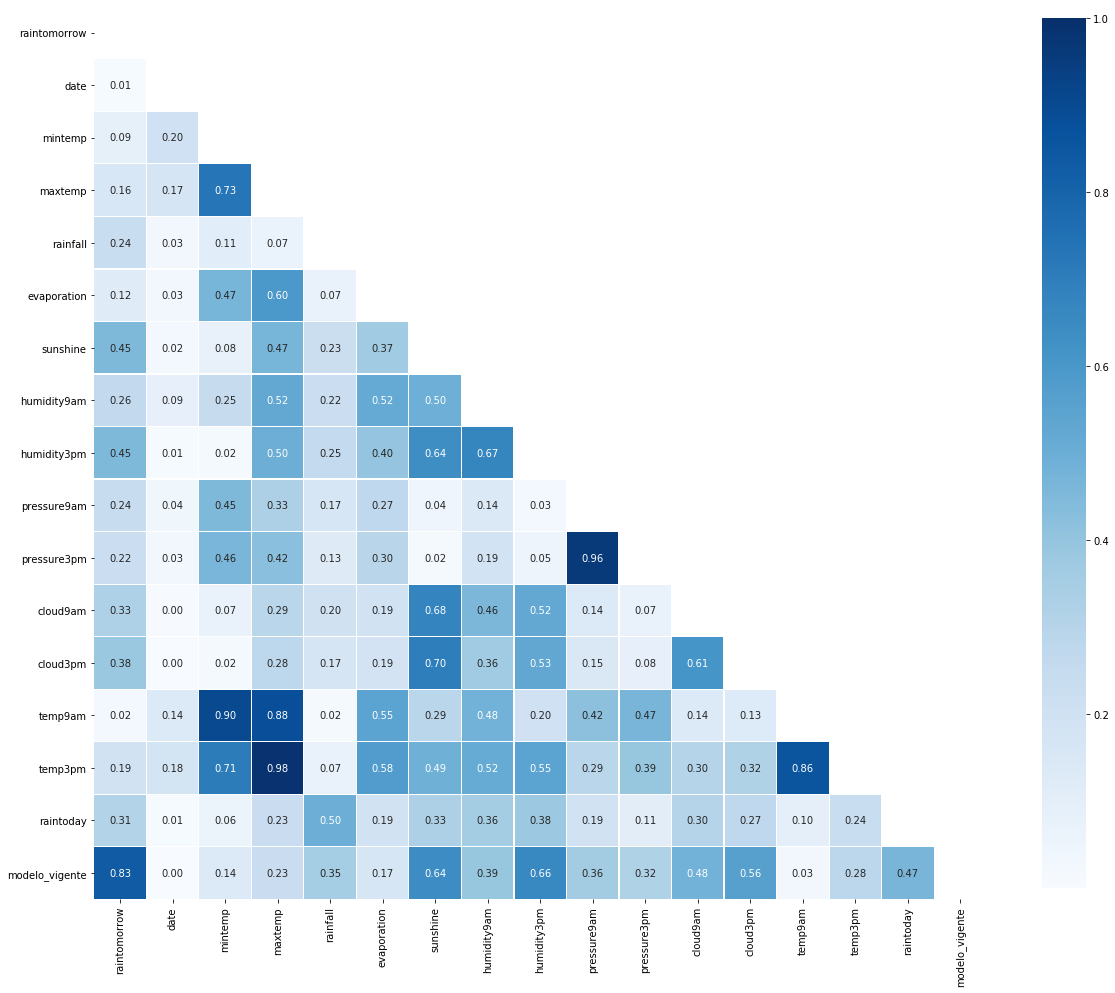

In [47]:
fig, ax = plt.subplots(figsize=(20, 20))
mask = np.zeros_like(df_train[rain_cols].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_train[rain_cols].corr().abs(),
            mask=mask,
            cmap='Blues',
            square=True,
            cbar_kws={"shrink": .8},
            linewidths=0.1,
            annot=True,
            fmt='.2f',
            ax=ax)
ax.set_ylim(len(df_train[rain_cols].corr()), 0, 0);

### Sunshine

In [48]:
df_train[rain_cols].corr().abs()[['sunshine']].sort_values('sunshine', ascending=False)

,sunshine
sunshine,1.000000
cloud3pm,0.702046
cloud9am,0.677462
modelo_vigente,0.640756
humidity3pm,0.636757
humidity9am,0.495686
temp3pm,0.490239
maxtemp,0.469472
raintomorrow,0.452852
evaporation,0.370132


In [49]:
features_sun = ['humidity3pm', 'humidity9am', 'temp3pm', 'maxtemp', 'raintoday']
cols_sun = ['sunshine', 'location'] + features_sun

df_sun_train = df_train[cols_sun].dropna(subset=['sunshine'], axis=0).reset_index(drop=True)

models_sun = {}
locations_sun = df_sun_train['location'].unique()
for l in locations_sun:
    poly = PolynomialFeatures(2, interaction_only=True)
    
    X_sun_train = df_sun_train.loc[df_sun_train['location'] == l]
    X_sun_train_poly = pd.DataFrame(poly.fit_transform(X_sun_train[features_sun]),
                                    columns=poly.get_feature_names(features_sun))
    y_sun_train = df_sun_train.loc[df_sun_train['location'] == l, 'sunshine']

    lm_reg = ElasticNetCV(l1_ratio=np.linspace(.1, 1, 10),
                          normalize=True,
                          max_iter=500000,
                          n_jobs=-1,
                          random_state=42)
    
    lm_reg.fit(X_sun_train_poly, y_sun_train)
    
    preds = lm_reg.predict(X_sun_train_poly)

    rmse_cv = mean_squared_error(y_sun_train, preds)
    
    models_sun[l] = {'estimator': lm_reg,
                     'weight': len(X_sun_train),
                     'cv rmse': rmse_cv}

    print('{}: cv rmse = {}'.format(l, rmse_cv))

Perth: cv rmse = 5.310908902295843
Canberra: cv rmse = 4.503640911649058
Nuriootpa: cv rmse = 6.900843440879286
Moree: cv rmse = 5.257172763094149
MelbourneAirport: cv rmse = 7.067899647562493
Portland: cv rmse = 9.654965386400535
Williamtown: cv rmse = 6.624457500318428
MountGambier: cv rmse = 7.701612882442554
Adelaide: cv rmse = 7.2870972728479355
Darwin: cv rmse = 3.4345565177737907
PerthAirport: cv rmse = 5.4147143394180475
Hobart: cv rmse = 7.4465486222330775
Sydney: cv rmse = 7.436364390255558
WaggaWagga: cv rmse = 5.865291067931492
Cairns: cv rmse = 4.4482114415406775
Mildura: cv rmse = 5.678684579088878
Dartmoor: cv rmse = 7.918933691780189
Watsonia: cv rmse = 7.519805198525059
Brisbane: cv rmse = 5.532160531052702
AliceSprings: cv rmse = 4.979096324699773
Townsville: cv rmse = 5.928819521699008
SydneyAirport: cv rmse = 7.554638649828589
CoffsHarbour: cv rmse = 5.671373153635095
Woomera: cv rmse = 7.343891672774216
Melbourne: cv rmse = 8.393671908940604
Sale: cv rmse = 7.56270

In [50]:
rmse_cv_ls = [models_sun[l]['cv rmse'] for l in locations_sun]
weight_ls = [models_sun[l]['weight'] for l in locations_sun]

avg_cv_rmse = np.average(rmse_cv_ls, weights=weight_ls)

print('avg cv rmse: {}'.format(avg_cv_rmse))

avg cv rmse: 6.4288846220410365


In [51]:
for l in locations_sun:
    poly = PolynomialFeatures(2, interaction_only=True)
    
    X_sun_train_imp = df_train.loc[(df_train['location'] == l) & (df_train['sunshine'].isnull()),
                                   features_sun]
    X_sun_test_imp = df_test.loc[(df_test['location'] == l) & (df_test['sunshine'].isnull()),
                                 features_sun]
    try:
        X_sun_train_imp_poly = pd.DataFrame(poly.fit_transform(X_sun_train_imp),
                                             columns=poly.get_feature_names(features_sun))
    except:
        continue
    else:
        try:
            X_sun_test_imp_poly = pd.DataFrame(poly.fit_transform(X_sun_test_imp),
                                               columns=poly.get_feature_names(features_sun))
        except:
            continue
            
    lm = models_sun[l]['estimator']
    
    df_train.loc[(df_train['location'] == l) & (df_train['sunshine'].isnull()), 'sunshine'] =\
    np.around(lm.predict(X_sun_train_imp_poly), decimals=1)
    df_test.loc[(df_test['location'] == l) & (df_test['sunshine'].isnull()), 'sunshine'] =\
    np.around(lm.predict(X_sun_test_imp_poly), decimals=1)

In [52]:
print(df_train.loc[df_train['sunshine'].notnull(), 'sunshine'].value_counts().sort_index())
print(df_test.loc[df_test['sunshine'].notnull(), 'sunshine'].value_counts().sort_index())

-4.0        1
-3.4        1
-2.3        1
-2.2        1
-2.0        7
-1.8        2
-1.7        3
-1.5        3
-1.4        3
-1.3        4
-1.2        7
-1.1        6
-1.0        6
-0.9        6
-0.8        4
-0.7        8
-0.6       10
-0.5       10
-0.4       17
-0.3        7
-0.2        7
-0.1       11
 0.0     1489
 0.1      348
 0.2      356
 0.3      268
 0.4      210
 0.5      225
 0.6      201
 0.7      231
 0.8      219
 0.9      225
 1.0      216
 1.1      190
 1.2      211
 1.3      200
 1.4      205
 1.5      221
 1.6      214
 1.7      211
 1.8      218
 1.9      227
 2.0      213
 2.1      216
 2.2      220
 2.3      243
 2.4      248
 2.5      215
 2.6      213
 2.7      248
 2.8      237
 2.9      235
 3.0      287
 3.1      201
 3.2      274
 3.3      245
 3.4      206
 3.5      258
 3.6      272
 3.7      233
 3.8      282
 3.9      255
 4.0      274
 4.1      307
 4.2      305
 4.3      328
 4.4      302
 4.5      324
 4.6      316
 4.7      300
 4.8      313
 4.9  

In [53]:
df_train['sunshine'].mask(df_train['sunshine'] < 0, 0, inplace=True)
df_test['sunshine'].mask(df_test['sunshine'] < 0, 0, inplace=True)

print(df_train.loc[df_train['sunshine'].notnull(), 'sunshine'].value_counts().sort_index())
print(df_test.loc[df_test['sunshine'].notnull(), 'sunshine'].value_counts().sort_index())

0.0     1614
0.1      348
0.2      356
0.3      268
0.4      210
0.5      225
0.6      201
0.7      231
0.8      219
0.9      225
1.0      216
1.1      190
1.2      211
1.3      200
1.4      205
1.5      221
1.6      214
1.7      211
1.8      218
1.9      227
2.0      213
2.1      216
2.2      220
2.3      243
2.4      248
2.5      215
2.6      213
2.7      248
2.8      237
2.9      235
3.0      287
3.1      201
3.2      274
3.3      245
3.4      206
3.5      258
3.6      272
3.7      233
3.8      282
3.9      255
4.0      274
4.1      307
4.2      305
4.3      328
4.4      302
4.5      324
4.6      316
4.7      300
4.8      313
4.9      297
5.0      337
5.1      308
5.2      347
5.3      331
5.4      327
5.5      389
5.6      343
5.7      378
5.8      369
5.9      358
6.0      423
6.1      438
6.2      423
6.3      428
6.4      392
6.5      380
6.6      423
6.7      381
6.8      456
6.9      418
7.0      449
7.1      475
7.2      513
7.3      534
7.4      452
7.5      489
7.6      480

### Evaporation

In [54]:
df_train[rain_cols].corr().abs()[['evaporation']].sort_values('evaporation', ascending=False)\

,evaporation
evaporation,1.000000
maxtemp,0.597315
temp3pm,0.578917
temp9am,0.550184
humidity9am,0.516375
mintemp,0.470745
humidity3pm,0.400458
sunshine,0.343799
pressure3pm,0.296432
pressure9am,0.271881


In [55]:
features_evap = ['maxtemp', 'temp3pm', 'temp9am', 'humidity9am', 'mintemp', 'humidity3pm']
cols_evap = ['evaporation', 'location'] + features_evap

df_evap_train = df_train[cols_evap].dropna(subset=['evaporation'], axis=0).reset_index(drop=True)

models_evap = {}
locations_evap = df_evap_train['location'].unique()
for l in locations_evap:
    poly = PolynomialFeatures(2, interaction_only=True)
    
    X_evap_train = df_evap_train.loc[df_evap_train['location'] == l]
    X_evap_train_poly = pd.DataFrame(poly.fit_transform(X_evap_train[features_evap]),
                                    columns=poly.get_feature_names(features_evap))
    y_evap_train = df_evap_train.loc[df_evap_train['location'] == l, 'evaporation']

    lm_reg = ElasticNetCV(l1_ratio=np.linspace(.1, 1, 10),
                          normalize=True,
                          max_iter=500000,
                          n_jobs=-1,
                          random_state=42)
    
    lm_reg.fit(X_evap_train_poly, y_evap_train)
    
    preds = lm_reg.predict(X_evap_train_poly)

    rmse_cv = mean_squared_error(y_evap_train, preds)
    
    models_evap[l] = {'estimator': lm_reg,
                     'weight': len(X_evap_train),
                     'cv rmse': rmse_cv}

    print('{}: cv rmse = {}'.format(l, rmse_cv))

Woomera: cv rmse = 48.16369469213695
Perth: cv rmse = 2.9534504177776935
Canberra: cv rmse = 2.994319347815384
Nuriootpa: cv rmse = 6.878730090310134
Moree: cv rmse = 29.5362572635219
MelbourneAirport: cv rmse = 4.093369996960426
Cobar: cv rmse = 12.332991269013682
Portland: cv rmse = 3.096958813173134
Williamtown: cv rmse = 37.96554222817501
MountGambier: cv rmse = 2.635622295289172
Darwin: cv rmse = 2.6793781852803282
Adelaide: cv rmse = 18.227279277485678
PerthAirport: cv rmse = 3.191757508868197
Hobart: cv rmse = 3.1740355954887813
Sydney: cv rmse = 3.9014774857016516
WaggaWagga: cv rmse = 6.516568789429765
Cairns: cv rmse = 5.230799219533969
Mildura: cv rmse = 4.898644483796434
Dartmoor: cv rmse = 2.688869887167615
Watsonia: cv rmse = 3.9416154476748155
Brisbane: cv rmse = 3.152916254781051
AliceSprings: cv rmse = 15.882873027646706
Townsville: cv rmse = 3.6904785550473256
SydneyAirport: cv rmse = 3.95120152322167
Richmond: cv rmse = 16.412669037600182
NorfolkIsland: cv rmse = 6.2

In [56]:
rmse_cv_ls = [models_evap[l]['cv rmse'] for l in locations_evap]
weight_ls = [models_evap[l]['weight'] for l in locations_evap]

avg_cv_rmse = np.average(rmse_cv_ls, weights=weight_ls)

print('avg cv rmse: {}'.format(avg_cv_rmse))

avg cv rmse: 8.2396784021748


In [57]:
for l in locations_evap:
    poly = PolynomialFeatures(2, interaction_only=True)
    
    X_evap_train_imp = df_train.loc[(df_train['location'] == l) & (df_train['evaporation'].isnull()),
                                   features_evap]
    X_evap_test_imp = df_test.loc[(df_test['location'] == l) & (df_test['evaporation'].isnull()),
                                 features_evap]
    try:
        X_evap_train_imp_poly = pd.DataFrame(poly.fit_transform(X_evap_train_imp),
                                             columns=poly.get_feature_names(features_evap))
    except:
        continue
    else:
        try:
            X_evap_test_imp_poly = pd.DataFrame(poly.fit_transform(X_evap_test_imp),
                                               columns=poly.get_feature_names(features_evap))
        except:
            continue
            
    lm = models_evap[l]['estimator']
    
    df_train.loc[(df_train['location'] == l) & (df_train['evaporation'].isnull()), 'evaporation'] =\
    np.around(lm.predict(X_evap_train_imp_poly), decimals=1)
    df_test.loc[(df_test['location'] == l) & (df_test['evaporation'].isnull()), 'evaporation'] =\
    np.around(lm.predict(X_evap_test_imp_poly), decimals=1)

In [58]:
print(df_train.loc[df_train['evaporation'].notnull(), 'evaporation'].value_counts().sort_index())
print(df_test.loc[df_test['evaporation'].notnull(), 'evaporation'].value_counts().sort_index())

-1.7        1
-1.3        2
-1.0        2
-0.9        4
-0.8        3
-0.6        6
-0.5        1
-0.4        5
-0.3        2
-0.2        8
-0.1        8
 0.0      138
 0.1       13
 0.2      318
 0.3       15
 0.4      525
 0.5       38
 0.6      735
 0.7       67
 0.8      904
 0.9       72
 1.0     1062
 1.1      102
 1.2     1177
 1.3      124
 1.4     1202
 1.5      136
 1.6     1308
 1.7      125
 1.8     1367
 1.9      140
 2.0     1454
 2.1      140
 2.2     1433
 2.3      144
 2.4     1407
 2.5      111
 2.6     1430
 2.7      153
 2.8     1392
 2.9      153
 3.0     1388
 3.1      152
 3.2     1321
 3.3      144
 3.4     1374
 3.5      170
 3.6     1350
 3.7      136
 3.8     1274
 3.9      137
 4.0     2254
 4.1      144
 4.2     1053
 4.3      169
 4.4     1152
 4.5      140
 4.6     1140
 4.7      149
 4.8     1201
 4.9      133
 5.0     1302
 5.1      131
 5.2     1156
 5.3      143
 5.4     1162
 5.5      146
 5.6     1156
 5.7      143
 5.8     1109
 5.9      121
 6.0  

In [59]:
df_train['evaporation'].mask(df_train['evaporation'] < 0, 0, inplace=True)
df_test['evaporation'].mask(df_test['evaporation'] < 0, 0, inplace=True)

print(df_train.loc[df_train['evaporation'].notnull(), 'evaporation'].value_counts().sort_index())
print(df_test.loc[df_test['evaporation'].notnull(), 'evaporation'].value_counts().sort_index())

0.0      180
0.1       13
0.2      318
0.3       15
0.4      525
0.5       38
0.6      735
0.7       67
0.8      904
0.9       72
1.0     1062
1.1      102
1.2     1177
1.3      124
1.4     1202
1.5      136
1.6     1308
1.7      125
1.8     1367
1.9      140
2.0     1454
2.1      140
2.2     1433
2.3      144
2.4     1407
2.5      111
2.6     1430
2.7      153
2.8     1392
2.9      153
3.0     1388
3.1      152
3.2     1321
3.3      144
3.4     1374
3.5      170
3.6     1350
3.7      136
3.8     1274
3.9      137
4.0     2254
4.1      144
4.2     1053
4.3      169
4.4     1152
4.5      140
4.6     1140
4.7      149
4.8     1201
4.9      133
5.0     1302
5.1      131
5.2     1156
5.3      143
5.4     1162
5.5      146
5.6     1156
5.7      143
5.8     1109
5.9      121
6.0     1223
6.1      104
6.2     1035
6.3      114
6.4     1026
6.5      109
6.6     1100
6.7      128
6.8      952
6.9       94
7.0     1008
7.1       83
7.2      917
7.3       78
7.4      858
7.5       83
7.6      818

### Cloud 3pm

,cloud3pm
cloud3pm,1.000000
sunshine,0.681456
cloud9am,0.611167
modelo_vigente,0.559495
humidity3pm,0.528562
raintomorrow,0.383085
humidity9am,0.363677
temp3pm,0.318298
maxtemp,0.279117
raintoday,0.271349


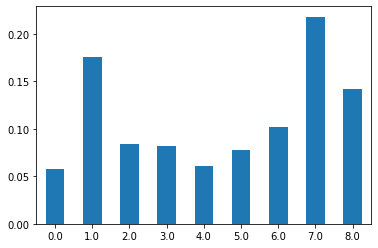

In [60]:
df_train['cloud3pm'].value_counts(normalize=True).sort_index().plot.bar(rot=0);
df_train[rain_cols].corr().abs()[['cloud3pm']].sort_values('cloud3pm', ascending=False)

In [61]:
features_cloud3pm = ['humidity3pm', 'humidity9am', 'temp3pm']
cols_cloud3pm = ['cloud3pm', 'location'] + features_cloud3pm

df_cloud3pm_train = df_train[cols_cloud3pm].dropna(subset=['cloud3pm'], axis=0).reset_index(drop=True)

models_cloud3pm = {}
locations_cloud3pm = df_cloud3pm_train['location'].unique()
for l in locations_cloud3pm:
    poly = PolynomialFeatures(2, interaction_only=True)
    scaler = StandardScaler()
    
    X_cloud3pm_train = df_cloud3pm_train.loc[df_cloud3pm_train['location'] == l]
    X_cloud3pm_train_poly = pd.DataFrame(poly.fit_transform(X_cloud3pm_train[features_cloud3pm]),
                                    columns=poly.get_feature_names(features_cloud3pm))
    scaler.fit_transform(X_cloud3pm_train_poly)
    y_cloud3pm_train = df_cloud3pm_train.loc[df_cloud3pm_train['location'] == l, 'cloud3pm']

    lr_reg = LogisticRegressionCV(cv=3,
                                  penalty='elasticnet',
                                  scoring='neg_log_loss',
                                  solver='saga',
                                  max_iter=500000,
                                  tol=0.01,
                                  n_jobs=-1,
                                  multi_class='multinomial',
                                  random_state=42,
                                  l1_ratios=np.linspace(0.1, 1, 10))
    
    try:
        lr_reg.fit(X_cloud3pm_train_poly, y_cloud3pm_train)
    except:
        continue
    
    preds_proba = lr_reg.predict_proba(X_cloud3pm_train_poly)

    log_loss_cv = log_loss(y_cloud3pm_train, preds_proba)
    
    models_cloud3pm[l] = {'estimator': lr_reg,
                          'weight': len(X_cloud3pm_train),
                          'cv log loss': log_loss_cv}

    print('{}: cv log loss = {}'.format(l, log_loss_cv))

Perth: cv log loss = 1.8638087162012962
Canberra: cv log loss = 1.7687469064722199
Nuriootpa: cv log loss = 1.8875135187814445
Moree: cv log loss = 1.920177649558446
MelbourneAirport: cv log loss = 1.6678341398212184
Cobar: cv log loss = 1.8625035224504682
Portland: cv log loss = 1.6568957695434634
MountGambier: cv log loss = 1.767522998732597


/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Darwin: cv log loss = 1.7292168402256844
PerthAirport: cv log loss = 1.8399030650995853
Bendigo: cv log loss = 1.8151200213681895
Hobart: cv log loss = 1.8651972823982084
Sydney: cv log loss = 1.8639672758329273
WaggaWagga: cv log loss = 1.8543847355224459
Cairns: cv log loss = 1.7660050944602528
Wollongong: cv log loss = 1.5372034246866009
Mildura: cv log loss = 1.9378809447378083
Watsonia: cv log loss = 1.6853179702243746
Brisbane: cv log loss = 1.7705991982331721
AliceSprings: cv log loss = 1.91096367895415
Townsville: cv log loss = 1.7971544226582836
Sale: cv log loss = 1.9695890595443204
SydneyAirport: cv log loss = 1.9011984076897128
Albury: cv log loss = 1.5734890190549995


/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Katherine: cv log loss = 1.885117996690309
CoffsHarbour: cv log loss = 1.828908894467838
Woomera: cv log loss = 1.8827855668035143
Williamtown: cv log loss = 1.884604370481653
Melbourne: cv log loss = 1.7371270581772886
PearceRAAF: cv log loss = 1.8969464376902672


/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


In [62]:
locations_cloud3pm = models_cloud3pm.keys()

log_loss_cv_ls = [models_cloud3pm[l]['cv log loss'] for l in locations_cloud3pm]
weight_ls = [models_cloud3pm[l]['weight'] for l in locations_cloud3pm]

avg_cv_log_loss = np.average(log_loss_cv_ls, weights=weight_ls)

print('avg cv log loss: {}'.format(avg_cv_log_loss))

avg cv log loss: 1.8139493957325534


In [63]:
for l in locations_cloud3pm:
    poly = PolynomialFeatures(2, interaction_only=True)
    
    X_cloud3pm_train_imp = df_train.loc[(df_train['location'] == l) & (df_train['cloud3pm'].isnull()),
                                   features_cloud3pm]
    X_cloud3pm_test_imp = df_test.loc[(df_test['location'] == l) & (df_test['cloud3pm'].isnull()),
                                 features_cloud3pm]
    try:
        X_cloud3pm_train_imp_poly = pd.DataFrame(poly.fit_transform(X_cloud3pm_train_imp),
                                             columns=poly.get_feature_names(features_cloud3pm))
    except:
        continue
    else:
        try:
            X_cloud3pm_test_imp_poly = pd.DataFrame(poly.fit_transform(X_cloud3pm_test_imp),
                                               columns=poly.get_feature_names(features_cloud3pm))
        except:
            continue
            
    lr_reg = models_cloud3pm[l]['estimator']
    
    df_train.loc[(df_train['location'] == l) & (df_train['cloud3pm'].isnull()), 'cloud3pm'] =\
    np.around(lr_reg.predict(X_cloud3pm_train_imp_poly), decimals=1)
    df_test.loc[(df_test['location'] == l) & (df_test['cloud3pm'].isnull()), 'cloud3pm'] =\
    np.around(lr_reg.predict(X_cloud3pm_test_imp_poly), decimals=1)

### Cloud 9am

,cloud9am
cloud9am,1.000000
sunshine,0.660715
cloud3pm,0.591441
humidity3pm,0.523491
modelo_vigente,0.482397
humidity9am,0.459314
raintomorrow,0.325790
temp3pm,0.304477
raintoday,0.304133
maxtemp,0.287199


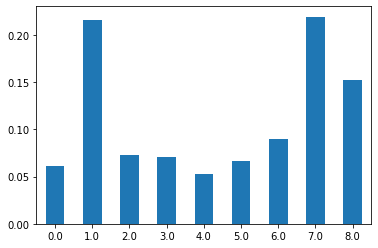

In [64]:
df_train['cloud3pm'].value_counts(normalize=True).sort_index().plot.bar(rot=0);
df_train[rain_cols].corr().abs()[['cloud9am']].sort_values('cloud9am', ascending=False)

In [65]:
features_cloud9am = ['humidity3pm', 'humidity9am', 'temp3pm', 'raintoday']
cols_cloud9am = ['cloud9am', 'location'] + features_cloud9am

df_cloud9am_train = df_train[cols_cloud9am].dropna(subset=['cloud9am'], axis=0).reset_index(drop=True)

models_cloud9am = {}
locations_cloud9am = df_cloud9am_train['location'].unique()
for l in locations_cloud9am:
    poly = PolynomialFeatures(2, interaction_only=True)
    scaler = StandardScaler()
    
    X_cloud9am_train = df_cloud9am_train.loc[df_cloud9am_train['location'] == l]
    X_cloud9am_train_poly = pd.DataFrame(poly.fit_transform(X_cloud9am_train[features_cloud9am]),
                                         columns=poly.get_feature_names(features_cloud9am))
    scaler.fit_transform(X_cloud9am_train_poly)
    y_cloud9am_train = df_cloud9am_train.loc[df_cloud9am_train['location'] == l, 'cloud9am']

    lr_reg = LogisticRegressionCV(cv=3,
                                  penalty='elasticnet',
                                  scoring='neg_log_loss',
                                  solver='saga',
                                  max_iter=500000,
                                  tol=0.01,
                                  n_jobs=-1,
                                  multi_class='multinomial',
                                  random_state=42,
                                  l1_ratios=np.linspace(0.1, 1, 10))
    
    try:
        lr_reg.fit(X_cloud9am_train_poly, y_cloud9am_train)
    except:
        continue
    
    preds_proba = lr_reg.predict_proba(X_cloud9am_train_poly)

    log_loss_cv = log_loss(y_cloud9am_train, preds_proba)
    
    models_cloud9am[l] = {'estimator': lr_reg,
                          'weight': len(X_cloud9am_train),
                          'cv log loss': log_loss_cv}

    print('{}: cv log loss = {}'.format(l, log_loss_cv))

Woomera: cv log loss = 1.8259059800293242
Perth: cv log loss = 1.8516204452090093
Canberra: cv log loss = 1.8135263311932242
Nuriootpa: cv log loss = 1.9269343423021565
Moree: cv log loss = 1.8299585320959393
MelbourneAirport: cv log loss = 1.6756666227723096
Cobar: cv log loss = 1.7723397758720354
Portland: cv log loss = 1.629811170366975
Albury: cv log loss = 1.3940017439002206
Williamtown: cv log loss = 1.919867672206684
MountGambier: cv log loss = 1.8047311753732502
Ballarat: cv log loss = 1.7228571571033395
Darwin: cv log loss = 1.7691345830064362
PerthAirport: cv log loss = 1.8382673571950632
Hobart: cv log loss = 1.8493225915337563
Sydney: cv log loss = 1.896918168805595
WaggaWagga: cv log loss = 1.784470552672886
Richmond: cv log loss = 1.4627592672309677
Cairns: cv log loss = 1.831631263913846
Wollongong: cv log loss = 1.4992900735021975
Mildura: cv log loss = 1.881265050206475
Watsonia: cv log loss = 1.6794477209087377
Brisbane: cv log loss = 1.8646730649744625
AliceSprings: 

/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Katherine: cv log loss = 1.6507122574006348
CoffsHarbour: cv log loss = 1.801544064986075
Melbourne: cv log loss = 1.7677359839921445
PearceRAAF: cv log loss = 1.949418069099079
Uluru: cv log loss = 1.6820553717827478


In [66]:
locations_cloud9am = models_cloud9am.keys()

log_loss_cv_ls = [models_cloud9am[l]['cv log loss'] for l in locations_cloud9am]
weight_ls = [models_cloud9am[l]['weight'] for l in locations_cloud9am]

avg_cv_log_loss = np.average(log_loss_cv_ls, weights=weight_ls)

print('avg cv log loss: {}'.format(avg_cv_log_loss))

avg cv log loss: 1.7990488704538143


In [67]:
for l in locations_cloud9am:
    poly = PolynomialFeatures(2, interaction_only=True)
    
    X_cloud9am_train_imp = df_train.loc[(df_train['location'] == l) & (df_train['cloud9am'].isnull()),
                                   features_cloud9am]
    X_cloud9am_test_imp = df_test.loc[(df_test['location'] == l) & (df_test['cloud9am'].isnull()),
                                 features_cloud9am]
    try:
        X_cloud9am_train_imp_poly = pd.DataFrame(poly.fit_transform(X_cloud9am_train_imp),
                                             columns=poly.get_feature_names(features_cloud9am))
    except:
        continue
    else:
        try:
            X_cloud9am_test_imp_poly = pd.DataFrame(poly.fit_transform(X_cloud9am_test_imp),
                                               columns=poly.get_feature_names(features_cloud9am))
        except:
            continue
            
    lr_reg = models_cloud9am[l]['estimator']
    
    df_train.loc[(df_train['location'] == l) & (df_train['cloud9am'].isnull()), 'cloud9am'] =\
    np.around(lr_reg.predict(X_cloud9am_train_imp_poly), decimals=1)
    df_test.loc[(df_test['location'] == l) & (df_test['cloud9am'].isnull()), 'cloud9am'] =\
    np.around(lr_reg.predict(X_cloud9am_test_imp_poly), decimals=1)

### Final imputation

In [68]:
# imputer = KNNImputer(weights='distance')

# X_train_complete = imputer.fit_transform(X_train)
# X_train_complete = pd.DataFrame(X_train_complete, columns=X_train_complete.columns)
# X_test_complete = imputer.transform(X_test)
# X_test_complete = pd.DataFrame(X_test_complete, columns=X_test_complete.columns)

### Imputation results

In [69]:
# null counts after imputation
display(df_train.isnull().sum()[df_train.isnull().sum() > 0])
display(df_test.isnull().sum()[df_test.isnull().sum() > 0])

evaporation    21866
sunshine       25901
cloud9am       18225
cloud3pm       21321
dtype: int64

evaporation     9369
sunshine       11093
cloud9am        7812
cloud3pm        9096
dtype: int64

# Modelling and Evaluation

## Models results

In [70]:
# dropping rows with missing values
df_train = df_train.dropna(axis=0).reset_index(drop=True)
df_test = df_test.dropna(axis=0).reset_index(drop=True)

In [71]:
X_train = df_train.drop(['modelo_vigente', 'raintomorrow'], axis=1)
X_test = df_test.drop(['modelo_vigente', 'raintomorrow'], axis=1)

# encoding the categorical variables
cols_cat = ['date', 'location', 'windgustdir', 'winddir9am', 'winddir3pm']
X_train = pd.get_dummies(X_train, columns=cols_cat, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cols_cat, drop_first=True)

y_train = df_train['raintomorrow']
y_test = df_test['raintomorrow']

baseline_train = df_train['modelo_vigente']
baseline_test = df_test['modelo_vigente']

In [94]:
poly = PolynomialFeatures(2, interaction_only=True)
scaler = StandardScaler()

clf = LogisticRegressionCV(cv=3,
                           penalty='elasticnet',
                           scoring='neg_log_loss',
                           tol=0.01,
                           solver='saga',
                           max_iter=500000,
                           n_jobs=-1,
                           multi_class='multinomial',
                           random_state=42,
                           l1_ratios=np.linspace(0.1, 1, 10))

poly.fit_transform(X_train)
scaler.fit_transform(X_train)
clf.fit(X_train, y_train)

preds_train_proba = pd.Series(clf.predict_proba(X_train)[:, 1])
preds_test_proba = pd.Series(clf.predict_proba(X_test)[:, 1])

# assuming decision threshold = 0.5
preds_train_labels = pd.Series(clf.predict(X_train))
preds_test_labels = pd.Series(clf.predict(X_test))

# assuming decision threshold = 0.5
baseline_train_labels = pd.Series(baseline_train >= 0.5).astype('int')
baseline_test_labels = pd.Series(baseline_test >= 0.5).astype('int')

### My model

In [105]:
print('MY MODEL RESULTS\n')
print('train confusion matrix:')
print(confusion_matrix(y_train, preds_train_labels))
print()
print('test confusion matrix:')
print(confusion_matrix(y_test, preds_test_labels))

MY MODEL RESULTS

train confusion matrix:
[[38952  2098]
 [ 5723  5674]]

test confusion matrix:
[[16780   814]
 [ 2456  2443]]


### Benchmark model

BENCHMARK MODEL RESULTS

train confusion matrix:
[[40407   643]
 [ 2551  8846]]

test confusion matrix:
[[17319   275]
 [ 1129  3770]]

precision-recall curve:


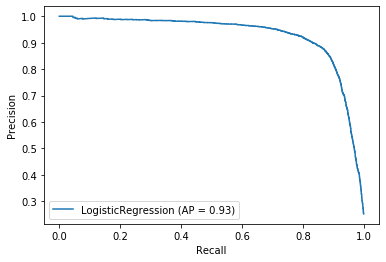

In [104]:
print('BENCHMARK MODEL RESULTS\n')
print('train confusion matrix:')
print(confusion_matrix(y_train, baseline_train_labels))
print()
print('test confusion matrix:')
print(confusion_matrix(y_test, baseline_test_labels))

### Stacking model

In [110]:
X_final_train = pd.concat([baseline_train, preds_train_proba],
                          keys=['modelo_vigente', 'meu_modelo'],
                          axis=1)
X_final_test = pd.concat([baseline_test, preds_test_proba],
                          keys=['modelo_vigente', 'meu_modelo'],
                          axis=1)

final_model = LogisticRegression()
final_model.fit(X_final_train, y_train)

preds_final_train = final_model.predict(X_final_train)# assuming decision threshold = 0.5
preds_final_test = final_model.predict(X_final_test) # assuming decision threshold = 0.5

print('STACKING MODEL RESULTS\n')
print('train confusion matrix:')
print(confusion_matrix(y_train, preds_final_train))
print()
print('test confusion matrix:')
print(confusion_matrix(y_test, preds_final_test))

STACKING MODEL RESULTS

train confusion matrix:
[[40111   939]
 [ 1611  9786]]

test confusion matrix:
[[17151   443]
 [  742  4157]]


## Precision-recall curves

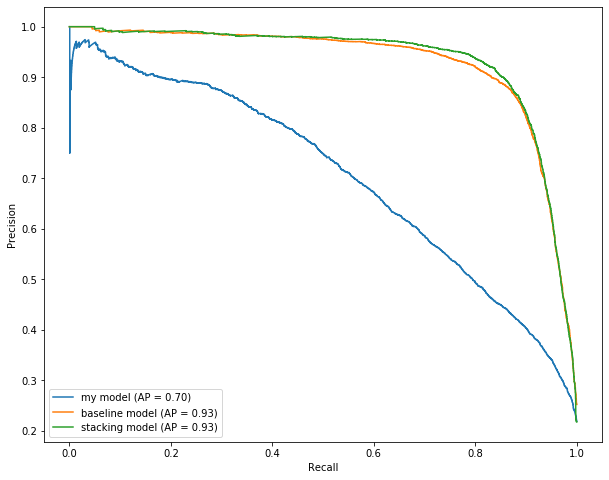

In [137]:
fig, ax = plt.subplots(figsize=(10,8))

plot_precision_recall_curve(clf, X_test,
                            y_test,
                            name='my model',
                            ax=ax)

precision, recall, _ = precision_recall_curve(y_test, baseline_test)
AP_baseline = average_precision_score(y_test, baseline_test)
plt.plot(recall, precision, label = 'baseline model (AP = {})'.format(np.around(AP_baseline, 2)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)

AP_stacking = average_precision_score(y_test, preds_final_test)
plot_precision_recall_curve(final_model,
                            X_final_test,
                            y_test,
                            name='stacking model',
                            ax=ax);